In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## load dataset

In [ ]:
filepath =  "/content/gdrive/MyDrive/2_train_sample.csv"
filepath2 =  "/content/gdrive/MyDrive/2_test_sample.csv"

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1=pd.read_csv(filepath,parse_dates=['CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM'])
df2=pd.read_csv(filepath2,parse_dates=['CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM'])

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df1.shape

(131028, 38)

In [ ]:
df2.shape

(38679, 38)

In [ ]:
#concat to make preprocess easier
df=pd.concat([df1,df2])

In [ ]:
df.shape

(169707, 38)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CMPLNT_NUM', 'CMPLNT_FR_DT',
       'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT',
       'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC', 'CRM_ATPT_CPTD_CD',
       'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
       'JURIS_DESC', 'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT',
       'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude',
       'Lat_Lon', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'New Georeferenced Column'],
      dtype='object')

In [ ]:
#split the time to create features like year,month,hour and dow
df['YEAR']=df['CMPLNT_FR_DT'].dt.year
df['MONTH']=df['CMPLNT_FR_DT'].dt.month
df['Hour']=df['CMPLNT_FR_TM'].dt.hour
df['DoW']=df['CMPLNT_FR_DT'].dt.dayofweek #sunday,monday...

In [ ]:
# Drop unnecessary columns
df.drop(labels=["Unnamed: 0", "Unnamed: 0.1","PARKS_NM",  "STATION_NAME", "PATROL_BORO", "TRANSIT_DISTRICT", 
             "SUSP_SEX", "SUSP_RACE", "SUSP_AGE_GROUP", "X_COORD_CD", "Y_COORD_CD", "HOUSING_PSA", "HADEVELOPT", 
             "JURISDICTION_CODE", "JURIS_DESC", "JURIS_DESC", "RPT_DT", "JURIS_DESC", "PREM_TYP_DESC",
             "PD_CD", "PD_DESC", "CMPLNT_TO_TM", "CMPLNT_TO_DT", "LOC_OF_OCCUR_DESC", "CMPLNT_FR_TM",'Latitude', 'Longitude','Lat_Lon','New Georeferenced Column'],axis=1,inplace=True)

In [ ]:
df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'ADDR_PCT_CD', 'KY_CD', 'OFNS_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'YEAR', 'MONTH', 'Hour', 'DoW'],
      dtype='object')

In [ ]:
#rename it
df.columns=['Complaint_ID','Date','Neighborhood','Offence_Code','Offence_Type','Status','Offence_Level','Borough','Victim_Agegroup','Victim_Race','Victim_Sex',
            'Year', 'Month','Hour', 'DoW']

In [ ]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4


## data preprocessing

1. missing value(delete all rows with null value)  
2. left join with holiday dataset to create the feature Holiday(0&1)  
3. control the category to remove some outlier  
4. label encoder to turn text to numerical value

In [ ]:
#dealing with missing value
df.isnull().sum().sort_values(ascending=False)

Borough            191
Status              11
Victim_Race          8
Offence_Type         3
Neighborhood         2
Complaint_ID         0
Date                 0
Offence_Code         0
Offence_Level        0
Victim_Agegroup      0
Victim_Sex           0
Year                 0
Month                0
Hour                 0
DoW                  0
dtype: int64

In [ ]:
#delete all rows with null value
df.dropna(how='any',axis=0,inplace=True)

In [ ]:
#left join with holiday to create the feature Holiday with bonary value,dataset from Kaggle https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021, add 2022 data manually
filepath3 =  "/content/gdrive/MyDrive/US_Holiday.csv"
df3=pd.read_csv(filepath3,parse_dates=['Date'],usecols=['Date','Holiday'],encoding = 'unicode_escape')
df3.head()

,Date,Holiday
0,2004-07-04,4th of July
1,2005-07-04,4th of July
2,2006-07-04,4th of July
3,2007-07-04,4th of July
4,2008-07-04,4th of July


In [ ]:
df=pd.merge(df,df3,left_on='Date',right_on='Date',how='left')
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,NaN
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,NaN
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,NaN
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,NaN
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,NaN


In [ ]:
#create Holiday
df['Holiday'].fillna(value=0,inplace=True)
df.loc[df['Holiday']!=0,'Holiday']=1

In [ ]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,0
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,0
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,0
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,0


In [ ]:
#control the category
df=df[df['Borough'].isin(['BROOKLYN','BRONX','QUEENS','MANHATTAN','STATEN ISLAND'])]
df=df[df['Victim_Sex'].isin(['F','M','D','E'])]
df=df[df['Victim_Agegroup'].isin(['25-44','45-64','18-24','65+','<18','UNKNOWN'])]
df=df[df['Victim_Race'].isin(['WHITE', 'WHITE HISPANIC', 'ASIAN / PACIFIC ISLANDER', 'BLACK','UNKNOWN', 'BLACK HISPANIC', 'AMERICAN INDIAN/ALASKAN NATIVE'])]

In [ ]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,0
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,0
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,0
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,0


In [ ]:
#label encoder, map the class to a distinct number
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
le.fit(df['Offence_Type'])
df['Offence_Type']=le.transform(df['Offence_Type'])
le.fit(df['Status'])
df['Status']=le.transform(df['Status'])
le.fit(df['Offence_Level'])
df['Offence_Level']=le.transform(df['Offence_Level'])
le.fit(df['Borough'])
df['Borough']=le.transform(df['Borough'])
le.fit(df['Victim_Agegroup'])
df['Victim_Agegroup']=le.transform(df['Victim_Agegroup'])
le.fit(df['Victim_Sex'])
df['Victim_Sex']=le.transform(df['Victim_Sex'])
le.fit(df['Victim_Race'])
df['Victim_Race']=le.transform(df['Victim_Race'])

In [ ]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,5,1,1,3,2,5,2,2020,11,13,6,0
1,349840324,2019-01-26,68.0,341,48,1,1,1,5,4,0,2019,1,18,5,0
2,355831147,2021-07-19,79.0,351,10,1,1,1,2,2,2,2021,7,14,0,0
3,934500497,2020-01-19,19.0,341,48,1,1,2,5,4,0,2020,1,17,6,0
4,988492438,2021-09-24,47.0,347,28,1,1,0,5,4,1,2021,9,4,4,0


In [ ]:
#split the training and test dataset
df_train=df.loc[df['Year']!=2022]
df_test=df.loc[df['Year']==2022]

In [ ]:
df_train.shape

(130807, 16)

In [ ]:
df_test.shape

(38554, 16)

## feature selection

1. Based on our EDA (Please refer to **Crime_EDA.ipynb**) on spatial-temporal factors, victim profile, and crime status, we decided to select the following features: ['Neighborhood', 'Hour', 'Year', 'Month', 'Holiday','Status', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup','Victim_Race']

2. We also used RandomForest to choose feature-- but it failed because it doesn't align with the importance in LogisticRegression

In [ ]:
#get x_train,y_train,x_test and y_test
#feature=['Neighborhood', 'Offence_Code', 'Hour', 'Year', 'Month', 'Holiday','Offence_Type', 'Status', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup']
feature=['Neighborhood', 'Hour', 'Year', 'Month', 'Holiday','Status', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup','Victim_Race']
x_train=df_train[feature]
y_train=df_train['Offence_Level']
x_test=df_test[feature]
y_test=df_test['Offence_Level']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
model = rf.fit(x_train,y_train)
importances = model.feature_importances_

[ 0  1  3  8  9 10  2  7  6  4  5]


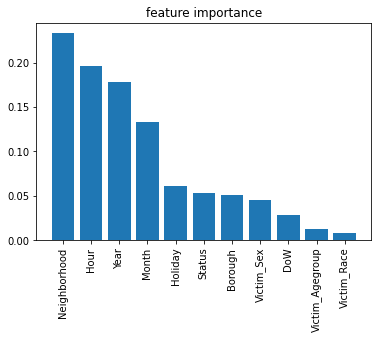

In [ ]:
indices = np.argsort(importances)[::-1]
print(indices)
# 获取特征名字
names = x_train.columns
# 创建图
plt.figure()
plt.title("feature importance")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation=90)
plt.show()

## LogisticRegression- baseline model

1.Use total random 10% dataset， used to show the data imbalance problem

In [ ]:
from sklearn.linear_model import LogisticRegression
linreg = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=2000)
model=linreg.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
#accuracy in train
y_pred2=linreg.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.5187800963081862

In [ ]:
#accuracy in test dataset
y_pred = linreg.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.5088995712615305

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12719
           1       0.51      1.00      0.67     19585
           2       0.00      0.00      0.00      6181

    accuracy                           0.51     38485
   macro avg       0.17      0.33      0.22     38485
weighted avg       0.26      0.51      0.34     38485



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


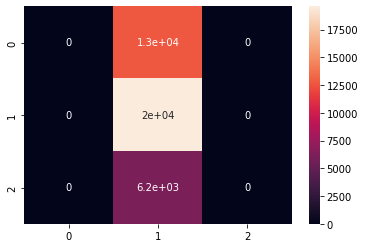

In [ ]:
import seaborn as sns
#we could see the imbalance here
cf_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
#the importance of each parameter
coef_c1 = pd.DataFrame({'var' : pd.Series(x_train.columns),
             'coef_abs' : abs(pd.Series(linreg.coef_[0].flatten()))})
coef_c1 = coef_c1.sort_values(by = 'coef_abs',ascending=False)
print(coef_c1)

               var  coef_abs
9  Victim_Agegroup  0.097201
5           Status  0.020371
1             Hour  0.008731
3            Month  0.005199
6          Borough  0.002933
8              DoW  0.002924
7       Victim_Sex  0.001382
4          Holiday  0.001319
0     Neighborhood  0.000598
2             Year  0.000001


2. Use Stratified Sampling dataset

In [ ]:
#get x_train,y_train,x_test and y_test
#feature=['Neighborhood', 'Offence_Code', 'Hour', 'Year', 'Month', 'Holiday','Offence_Type', 'Status', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup']
feature=['Neighborhood','Hour','Year','Month','Holiday','Status','Borough','Victim_Sex','DoW','Victim_Agegroup','Victim_Race']
x_train=df_train[feature]
y_train=df_train['Offence_Level']
x_test=df_test[feature]
y_test=df_test['Offence_Level']

In [ ]:
from sklearn.linear_model import LogisticRegression
linreg = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=2000)
model=linreg.fit(x_train, y_train)

In [ ]:
#the importance of each feature
coef_c1 = pd.DataFrame({'var' : pd.Series(x_train.columns),
             'coef_abs' : abs(pd.Series(linreg.coef_[0].flatten()))})
coef_c1 = coef_c1.sort_values(by = 'coef_abs',ascending=False)
print(coef_c1)

               var  coef_abs
9  Victim_Agegroup  0.125831
5           Status  0.096525
7       Victim_Sex  0.052653
6          Borough  0.013307
1             Hour  0.008082
3            Month  0.005565
4          Holiday  0.004599
8              DoW  0.001721
0     Neighborhood  0.000451
2             Year  0.000067


found that accuracy in test dataset is even higher than train_dataset, which may due to underfit, so we try to find a more 'complex' model to fit the data

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
#accuracy in train
y_pred2=linreg.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.40801333261981393

In [ ]:
#accuracy in test dataset 
y_pred = linreg.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.41648078020438867

In [ ]:
#Get the probability that the prediction is 1, in order to draw roc curve
pred_proba=linreg.predict_proba(x_test)
predict_odd=[]
for i in range(len(pred_proba)):
  possibility=pred_proba[i]
  predict_odd.append(possibility[1])

the imbalance phenomenom is better, but couldn't classify 0 well

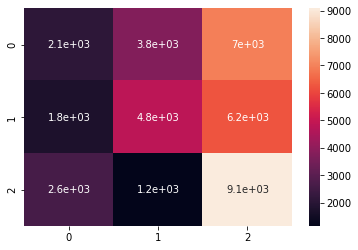

In [ ]:
import seaborn as sns
cf_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.32      0.16      0.22     12835
           1       0.49      0.38      0.43     12836
           2       0.41      0.70      0.52     12883

    accuracy                           0.42     38554
   macro avg       0.41      0.41      0.39     38554
weighted avg       0.41      0.42      0.39     38554



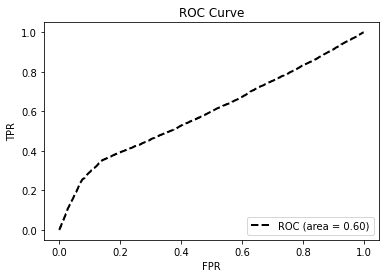

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thersholds = roc_curve(y_test, predict_odd, pos_label=1) 
roc_auc = auc(fpr, tpr) #get auc value
plt.figure()
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2) #画折线图
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## model choosing

compare common classification model by using 10-fold cross validation, use accuracy to compare. Found that AdaBoost is of the highest accuracy

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

LR: 0.409076 (0.003179)
LDA: 0.418525 (0.004404)
KNN: 0.394406 (0.003429)
CART: 0.400896 (0.003756)
NB: 0.439441 (0.005345)
SVM: 0.353353 (0.003242)
Ada: 0.469952 (0.004457)
RF: 0.446811 (0.002125)


NN: 0.332245 (0.003576)


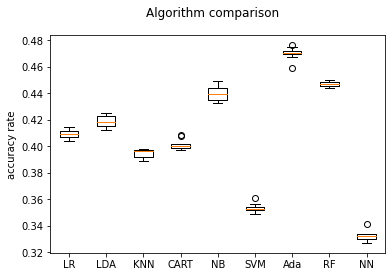

In [ ]:
validation_size = 0.2
seed = 7

models = {}
models['LR'] = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=5000)
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['SVM'] = SVC()
models['Ada']=AdaBoostClassifier()
models["RF"]=RandomForestClassifier()
models["NN"]=MLPClassifier(hidden_layer_sizes=(10,), random_state=10,learning_rate_init=0.1,max_iter=1000)
results = []
for key in models:
  kfold = KFold(n_splits=10,shuffle=True,random_state=seed)
  cv_results = cross_val_score(models[key],x_train,y_train,cv=kfold,scoring='accuracy')
  results.append(cv_results)
  print('%s: %f (%f)'%(key,cv_results.mean(),cv_results.std()))
fig = plt.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(models.keys())
ax.set_ylabel("accuracy rate")
plt.show()

## AdaBoost

Use Adaboost, find that the accuracy,auc is higher compare to LogisticRegression

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(x_train, y_train)

AdaBoostClassifier()

In [ ]:
#accuracy in train
y_pred2=clf.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.47125153852622564

In [ ]:
#accuracy in test
y_pred = clf.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.48246615137210147

[0 1 9 7 3 6 8 2 5 4]


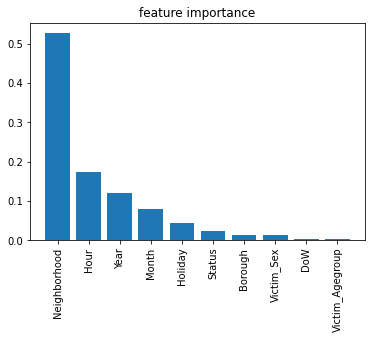

In [ ]:
#visualize the importance of feature
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = x_train.columns

plt.figure()
plt.title("feature importance")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation=90)
plt.show()

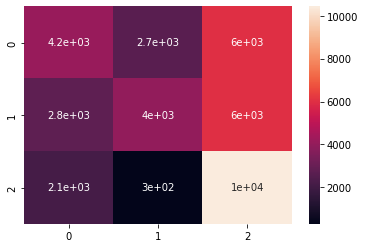

In [ ]:
cf_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.46      0.32      0.38     12835
           1       0.57      0.31      0.41     12836
           2       0.46      0.81      0.59     12883

    accuracy                           0.48     38554
   macro avg       0.50      0.48      0.46     38554
weighted avg       0.50      0.48      0.46     38554



In [ ]:
#Get the probability that the prediction is 1, in order to draw roc curve
pred_proba=clf.predict_proba(x_test)
predict_odd=[]
for i in range(len(pred_proba)):
  possibility=pred_proba[i]
  predict_odd.append(possibility[1])

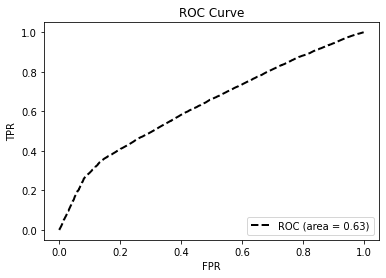

In [ ]:
fpr, tpr, thersholds = roc_curve(y_test, predict_odd, pos_label=1) 
roc_auc = auc(fpr, tpr) #get auc value
plt.figure()
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2) #画折线图
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Use GridSearch to find the best parameter combination, increasing the accuracy from 0.4824 to 0.4851

In [ ]:
from sklearn.model_selection import GridSearchCV
#parameter tuning with adaboost using GridSearch
parameters = {'n_estimators':[10,20,50,100,200,300], 'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.8,1.0,2.0,3.0]}
gs = GridSearchCV(clf,parameters,scoring='accuracy')
gs.fit(x_train,y_train)
print(gs.best_params_)
print(gs.best_score_)

{'learning_rate': 1.0, 'n_estimators': 300}
0.47103752874668714


In [ ]:
clf = AdaBoostClassifier(n_estimators=300,learning_rate=1.0)
clf.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=300)

In [ ]:
#accuracy in train
y_pred2=clf.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.47360615257593247

In [ ]:
#accuracy in test
y_pred = clf.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.48513772889972506

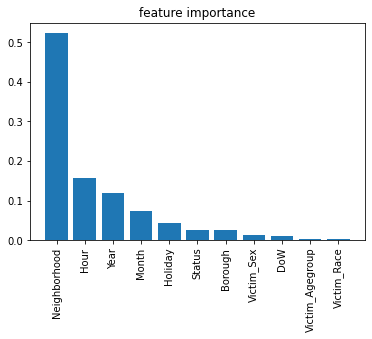

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = x_train.columns

plt.figure()
plt.title("feature importance")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation=90)
plt.show()

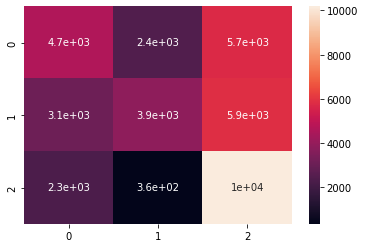

In [ ]:
cf_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.46      0.36      0.41     12835
           1       0.58      0.30      0.40     12836
           2       0.47      0.79      0.59     12883

    accuracy                           0.49     38554
   macro avg       0.50      0.48      0.46     38554
weighted avg       0.50      0.49      0.46     38554



In [ ]:
#Get the probability that the prediction is 1, in order to draw roc curve
pred_proba=clf.predict_proba(x_test)
predict_odd=[]
for i in range(len(pred_proba)):
  possibility=pred_proba[i]
  predict_odd.append(possibility[1])

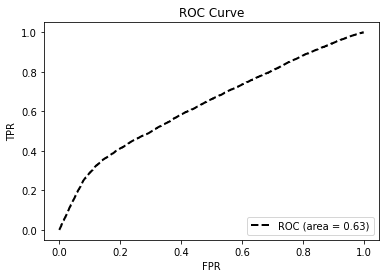

In [ ]:
fpr, tpr, thersholds = roc_curve(y_test, predict_odd, pos_label=1) 
roc_auc = auc(fpr, tpr) #get auc value
plt.figure()
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
model = rf.fit(x_train,y_train)

Find the model is overfit

In [ ]:
#accuracy in train
y_pred2=model.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.9932495967341197

In [ ]:
#accuracy in test
y_pred = model.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.4480987705555844

Tuning the model by using GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
#parameter tuning with adaboost using GridSearch
parameters = {'n_estimators':[10,20,50,100,200], 'max_depth':[1,3,5,10,15,20]}
gs = GridSearchCV(rf,parameters,scoring='accuracy')
gs.fit(x_train,y_train)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 10, 'n_estimators': 200}
0.48176322995016996


In [ ]:
rf = RandomForestClassifier(max_depth=10,n_estimators=200)
model = rf.fit(x_train,y_train)

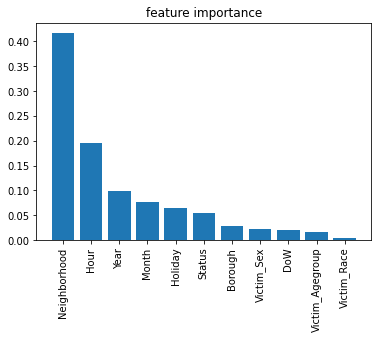

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = x_train.columns

plt.figure()
plt.title("feature importance")
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation=90)
plt.show()

In [ ]:
#accuracy in train
y_pred2=model.predict(x_train)
accuracy_score(y_true=y_train, y_pred=y_pred2)

0.49955277622757194

In [ ]:
#accuracy in test
y_pred = model.predict(x_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.49159620272864035

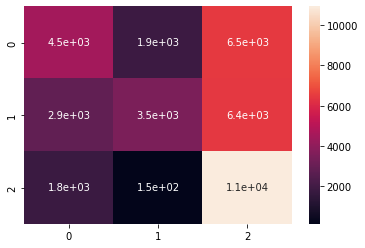

In [ ]:
cf_matrix=confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.49      0.35      0.41     12835
           1       0.64      0.27      0.38     12836
           2       0.46      0.85      0.60     12883

    accuracy                           0.49     38554
   macro avg       0.53      0.49      0.46     38554
weighted avg       0.53      0.49      0.46     38554



In [ ]:
#Get the probability that the prediction is 1, in order to draw roc curve
pred_proba=clf.predict_proba(x_test)
predict_odd=[]
for i in range(len(pred_proba)):
  possibility=pred_proba[i]
  predict_odd.append(possibility[1])

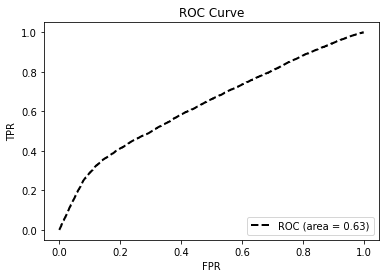

In [ ]:
fpr, tpr, thersholds = roc_curve(y_test, predict_odd, pos_label=1) 
roc_auc = auc(fpr, tpr) #get auc value
plt.figure()
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()